# 誤差理論與測量平差課程輔助程式
## 作者：黃明哲博士 (geodesy.cnu@gmail.com)
#### ch01_03_azdis_pos_CNU.ipynb
#### 平面點基本定位方法 (方位角+距離) 極坐標法 (光線法) 範例
#### 嘉南藥理大學校區測量實際案例

<img src="https://drive.google.com/uc?id=13Q_PTnPRf47xzE-QH6-Zj5cinVH6lcNz">


程式操作方法：
開啟本記事簿，輸入觀測點座標、原方向參考座標，<br />
點位號碼、觀測的距離、從參考原方向的方向角

即可獲得各點位的座標

In [14]:
!git clone https://github.com/geodesy-CNU/pygeodadj.git

fatal: destination path 'pygeodadj' already exists and is not an empty directory.


In [15]:
!ls pygeodadj

gnssnet  LSEA  notebooks  README.md  utils


In [0]:
%matplotlib inline

from pygeodadj.utils.adj_utils import azdis
from pygeodadj.utils.adj_utils import plot_azdis
from pygeodadj.utils.adj_utils import azdis_compute
from pygeodadj.utils.adj_utils import plot_azdis_pos
from pygeodadj.utils.adj_utils import dms2d
from pygeodadj.utils.adj_utils import azdis_pos_df

## 嘉南藥理大學案例，產生Shape file
## 嘉南藥理大學校內控制點配置圖
<img src="https://drive.google.com/uc?id=14ypUYV6OAOsw1Zhhmusu5l0UHpWgfoX0">


In [16]:
!cat pygeodadj/notebooks/02_azdis_pos/azdis_pos_cnu.txt

PtName,deg,min,sec,dist,xp,yp
obs, 0,0,0,0,170559.45, 2535801.064
ref, 0,0,0,0,170727.663, 2535774.677
 pt_1, 10,23,10,95.50,0.0,0.0
 pt_2, 32,45,30,120.53,0.0,0.0
 pt_3, 348,45,30,157.53,0.0,0.0

In [17]:
# test data
data_dir='pygeodadj/notebooks/02_azdis_pos/'
#data_dir='drive/My Drive/Colab Notebooks/courses/Lab4_Adjustment/'
path=data_dir+'azdis_pos_cnu.txt'
   
df=azdis_pos_df(path)
df.head()

,PtName,deg,min,sec,dist,xp,yp
0,obs,0,0,0.000000,0.000000,170559.450000,2.535801e+06
1,ref,98,54,54.511514,170.270042,170727.663000,2.535775e+06
2,pt_1,10,23,10.000000,95.500000,170649.582300,2.535769e+06
3,pt_2,32,45,30.000000,120.530000,170649.479409,2.535721e+06
4,pt_3,348,45,30.000000,157.530000,170716.850149,2.535807e+06


In [18]:
#顯示計算結果 
obs=df.loc[0]
xa=obs['xp']
ya=obs['yp']

ref=df.loc[1]
xb=ref['xp']
yb=ref['yp']
dis=ref['dist']
deg=ref['deg']
mm=ref['min']
sec=ref['sec']

print("觀測點：\t%.3f %.3f"%(xa,ya))
print("參考點：\t%.3f %.3f"%(xb,yb))
print("距離:\t %.3fm"%(dis))
print("參考方位： %3.3d度 %2.2d分%.2f秒"%(deg,mm,sec))

觀測點：	170559.450 2535801.064
參考點：	170727.663 2535774.677
距離:	 170.270m
參考方位： 098度 54分54.51秒


## 計算完的座標，可以產生圖檔嗎?
How about ESRI Shape file?

In [8]:
!pip install geopandas

     |████████████████████████████████| 921kB 4.8MB/s 
     |████████████████████████████████| 11.8MB 24.0MB/s 
     |████████████████████████████████| 10.1MB 34.9MB/s 


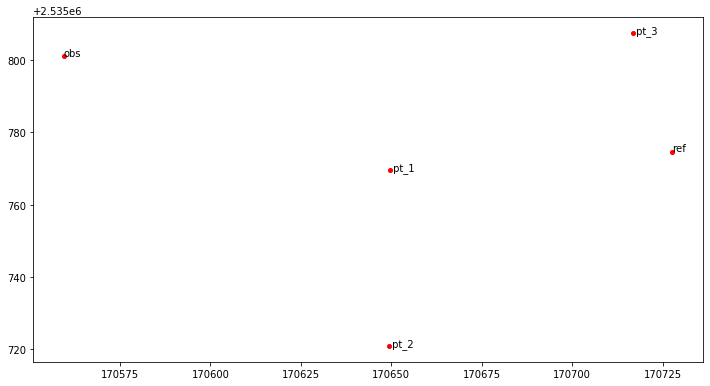

In [19]:
import geopandas as gpd
from shapely.geometry import Point

# creating a geometry column 
geometry = [Point(xy) for xy in zip(df['xp'], df['yp'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:3826'}

# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
# Plot all points
ax = gdf.plot(marker='o', color='r', markersize=16,figsize=(12, 20))
df.apply(lambda x: ax.annotate(s=x.PtName, xy=x.geometry.coords[0], ha='left'),axis=1)
gdf.to_file(data_dir+"azdis_pos_cnu.shp")

In [20]:
!ls 'pygeodadj/notebooks/02_azdis_pos/'

azdis_pos_cnu.cpg  ch01_01_azdis_Colab.ipynb
azdis_pos_cnu.dbf  ch01_01_azdis.ipynb
azdis_pos_cnu.prj  ch01_02_azdis_pos.ipynb
azdis_pos_cnu.shp  ch01_03_azdis_pos_CNU_Colab.ipynb
azdis_pos_cnu.shx  ch01_03_azdis_pos_CNU.ipynb
azdis_pos_cnu.txt  ch01_azdis_pos_Colab.ipynb
azdis_pos_out.txt  cnu_demo.png
azdis_pos.txt	   maps


## 課堂與真實世界的鴻溝

### 上面這個範例能夠直接產生Shape file已經是非常棒的結果了，還能更好嗎?
### 老師改作業能不能直接把結果畫在電子地圖上面直接繳交作業呢? 

在開始之前，我們先談談座標轉換。要把TWD97 (TM2/121)的 (E, N)座標轉換成WGS-84經緯度座標，我們可參考台灣常用的 EPSG代碼，找到幾個常用的EPSG代碼。

To transform TWD97 (TM2/121) E, N to lats and longs in WGS84, we will use pyproj and the EPSG spatial reference list. 


pyproj是PROJ4程式庫的Python介面，用於製圖轉換。

pyproj is a Python interface to PROJ4 library for cartographic transformations.

EPSG大地參數數據集註冊表將大地參數存儲為實體。 註冊表維護每個實體的生命週期信息，並管理整個數據集的發布。

The EPSG Geodetic Parameter Dataset Registry stores geodetic parameters as entities. The Registry maintains lifecycle information for each entity and manages releases of the entire dataset.

pyproj是一個易於使用的軟件包，是Python中最簡單的解決方案。 我們繼續使用WGS84的基準名稱和ED50的EPSG代碼轉換坐標。 在這兩者上，我們都使用地理上非投影的數據。 使用http://www.epsg-registry.org網站通過搜索基準名稱來提取EPSG代碼。 從WGS84 latlong到TWD97 TM2坐標的坐標轉換：

pyproj is a easy to use package and is the most simple solution for this in Python. Let's go ahead and transform the coordinates using the datum name for the WGS84 and the EPSG code for the ED50. On both we use geographic unprojected data. The EPSG code is extracted using the http://www.epsg-registry.org site by searching for the name of the datum. Coordinate transform from WGS84 latlong to the TWD97 TM2 coordinates:

In [13]:
import pyproj
import folium

#座標轉換，把測站位置放在地圖中心
WGS84 = pyproj.Proj(proj='latlong', datum='WGS84')
TWD97_TM2 = pyproj.Proj(init='epsg:3826')
lon, lat = pyproj.transform(TWD97_TM2,WGS84, xa, ya)

# 把測站位置放在地圖中心
cnu_pts = gpd.read_file(data_dir+'azdis_pos_cnu.shp')
m = folium.Map(location=[lat, lon], zoom_start=17)
folium.GeoJson(cnu_pts).add_to(m)
m

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
